# Classification with Keras

***MNIST dataset***<br>
Contains 70000 handwritten digits(60000 train, 10000 test), and labels for all the images.<br>
For more info:<br>
http://yann.lecun.com/exdb/mnist/

***Keras CNN MNIST*** example code can be found here:<br>
https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

Keep in mind, on a CPU the train could be take hours.<br>
On my laptop 2 epochs took ~1,5 hour. Compare with a GPU performance, it's a huge difference.<br>
GPU:<br>
```
60000/60000 [==============================] - 3s 49us/step - loss: 0.0286 - acc: 0.9914 - val_loss: 0.0294 - val_acc: 0.9910
Epoch 12/12
60000/60000 [==============================] - 3s 48us/step - loss: 0.0262 - acc: 0.9920 - val_loss: 0.0269 - val_acc: 0.9920
Test loss: 0.026884999596639453
Test accuracy: 0.992
```
Another option is train in the cloud.<br>
***Google Colaboratory*** is a nice starting point for that. They give free GPU time to train your model.<br>
For more info:<br>
https://colab.research.google.com/notebooks/welcome.ipynb

## CNNs

Convolutional Neural Networks are similar to simple artificial NNs. The only difference is, the network assumption is to use images as inputs. That allow us to encode properties to the network architecture.<br>
CNN = Artificial Neural Network + a set of operations we call Convolution.<br>

***Aritificial neurons*** simulate biological neurons in a limited way.<br>
![title](notebook_contents/artificial_neuron.jpeg)
The inputs represented as x1,x2, so on... which are connected to the activation function(f).<br>
The connection between the inputs(x), and the activation function(f) dawned by a set of weights, which are represented W1, W2, so on...<br>
Besides this, we have a bias(b). -TODO replace image<br>
After applying the output of the activation function we got the 'output' as well, which is a function applied to the input, weighted by W and the bias.

***Convolution***<br>
![title](notebook_contents/convolution.jpg)
For now we stay at images.<br>
We have a single input image, and we apply a filter(also known as kerner,mask) on it.<br>
The image can represent as pixels*pixels, and if we use greyscaled pictures, the number between [0,255].<br>
We get the result of the convolutional by combining the input window, weighted by the values inside the filter.<br>
In this case the kernel was:
```
W0(1,0,1)
W1(0,1,0)
W2(1,0,1)
```

### CNN applied for image classification

    Firs layer is one or more layers of convolution.
    After this we apply one or more steps of pooling.
    We design a fully connected layer.
    At the end we use some classification, like softmax.

We use this method to create our CNN to classify digits on images from 0-9.<br>
Let's get stated.

First let's ***import the libraries*** we will use.<br>
Keras will download the dataset for us.<br>
backend - At this time, Keras has three backend implementations available: the TensorFlow backend, the Theano backend, and the CNTK backend. We use TensorFlow by default. You can check/change it in your /home/.keras/keras.json file.

In [9]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import TensorBoard

tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)

***batch_size =*** Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.<br>
For more info:<br>
https://keras.io/models/sequential/<br>
***num_class =*** Just the classes we want to distinguish. In this case numbers from '0' to '9'.<br>
***epochs =*** Integer. Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided.<br>
For more info:<br>
https://keras.io/models/sequential/

In [10]:
# define random.seed for reproducibility
seed = 7
np.random.seed(seed)

batch_size = 128
num_classes = 10
epochs = 12

***Load the dataset images, and split them to train, and test datas.***

In [11]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

***Check the dataset:***<br>
Lets take a look some of the train images. Every image(x_train) has a label(y_train).<br>
Train image shape shows the actual image's shape. In this case we have 60000 images with 28x28 pixels.<br>
Train labels shape just a 1D array that represent the actual/correct output for the images.

train images shape:(60000, 28, 28)
train labels shape:[5 0 4 ... 5 6 8]


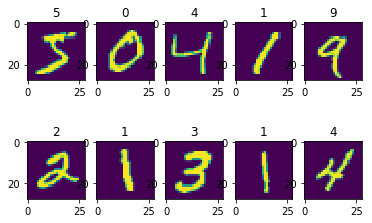

In [12]:
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[i])
    plt.title("{}".format(y_train[i]))
print("train images shape:{}\ntrain labels shape:{}".format(x_train.shape, y_train))

***Resize the images rows', and columbs' for faster processing.<br>***
The 28x28 is a good starting point for hand written characters. As you can see above, the rows, and cols are already 28x28 pixels.<br>
Also the model needs to know what input shape it should expect. For this reason, the first layer in a Sequential model (and only the first, because following layers can do automatic shape inference) needs to receive information about its input shape.

In [13]:
# input image dimensions
img_rows, img_cols = 28, 28
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

***Normalize the the datas.<br>***
This is proprocessing step where we convert our data to float32 type, and normalize between range [0,1].<br>
Almost all of the ML algorithms have better results if we normalize the datas, and also the converge can be much faster -> that improves the learning rate.

In [14]:
# normalization
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


***The keras.utils.to_categorical function:***
Use keras.utils.to_categorical on the train/test labels to converts a class vector (integers) to binary class matrix, because we will use categorical_crossentropy as well.<br>
E.g.:
```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
etc.
```


In [15]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Before we start the training, some useful information:

### We use Sequential model:
A linear stack of layers.<br>
For more info:<br>
https://keras.io/models/sequential/<br>
https://keras.io/getting-started/sequential-model-guide/
### Dense layer(aka. fully connected layer): 
Just your regular densely-connected NN layer. Where all the input is connected to all the outputs by a weight. Generally followed by an activation function. The layer has a weight matrix(w), a bias(b), and an activation(a).
Other layers: Convolutional, Pooling, Normalisation, etc.<br>
keras.layers.Dense(units, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)<br>
For more info:<br>
https://keras.io/layers/core/<br>
Also check out how can you create your own layer in Keras:<br>
https://keras.io/layers/writing-your-own-keras-layers/
### Conv2D is a 2D convolution layer (e.g. spatial convolution over images).
This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs. If use_bias is True, a bias vector is created and added to the outputs. Finally, if activation is not None, it is applied to the outputs as well. When using this layer as the first layer in a model, provide the keyword argument input_shape.<br>
keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)<br>
For more info:<br>
https://keras.io/layers/convolutional/
### Dropout 
is a techniq to tackle overfitting. While the network is learning the weights of the neurons are tuned for specific features. Connected neurons have effect on this. If it's going too far, the model will be specialize for the training data. With dropout the model will be more adaptive. If we drop out randomly some neurons the other neurons have to step in and learn the predictions for the missing neurons. The network becomes less sensitive to the specific weights of neurons.<br>
keras.layers.Dropout(rate, noise_shape=None, seed=None)<br>
For more info:<br>
https://keras.io/layers/core/#dropout
### MaxPooling2D 
is a sample-based discretization process. We can down-sample the input representation, but keep the most important informations.<br>
keras.layers.MaxPooling1D(pool_size=2, strides=None, padding='valid', data_format='channels_last')<br>
For more info:<br>
https://keras.io/layers/pooling/<br>
https://www.quora.com/What-is-max-pooling-in-convolutional-neural-network<br>

#### Also
Check the loss functions:<br>
https://keras.io/losses/<br>
Check optimizers:<br>
https://keras.io/optimizers/<br>
Check the available activation functions:<br>
https://keras.io/activations/

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[tensorboard])

model.save('MNIST.h5')

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

The below code is only for testing purpose right now.<br>
You have to save the picture before you do predict on it.<br>
Still working on a robust solution for this.<br>
I'll update with the final version, if it's available.<br>
To use you have to change from 'Markdown' to 'Code'.

import matplotlib.pyplot as plt
import PIL
import numpy as np
import cv2
from tkinter import *
from PIL import ImageTk, Image, ImageDraw
from keras.preprocessing.image import img_to_array, load_img
from keras.models import load_model
import os
#import base64
%matplotlib inline

canvas_width = 280
canvas_height = 280
line_width = int(canvas_width/10)
image_width= 28
image_height = 28
white = (255, 255, 255)
green = (0,128,0)
image_number = 0

def save(): #TODO now we have to save the image first to do predict.
    global image_number
    filename = f'image_{image_number}.jpg'
    image.save(filename)
    image_number += 1
    
def paint(event):
    # python_green = "#476042"
    x1, y1 = (event.x - 1), (event.y - 1)
    x2, y2 = (event.x + 1), (event.y + 1)
    cv.create_oval(x1, y1, x2, y2, fill="black",width=line_width)
    draw.line([x1, y1, x2, y2],fill="black",width=line_width)
        
def prediction():
    global image_number
    model = load_model('MNIST.h5')
    img = load_img(f'image_{image_number-1}.jpg')
    img = np.asarray(img)
    img = cv2.resize(img,(image_width, image_height)) 
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    #plt.imshow(x)
    preds = model.predict_classes(x)
    prob = model.predict_proba(x)
    try:
        cv.delete(T)
    except:
        pass
    T = Text(root, height=1, width=14)
    T.pack()
    T.insert(END, "Prediction:{}".format(preds[0]))
    
    print(preds, prob)

root = Tk()
root.title("Predict")
root.configure(background='white')
# Tkinter create a canvas to draw on
cv = Canvas(root, width=canvas_width, height=canvas_height, bg='white')

# PIL create an empty image and draw object to draw on
# memory only, not visible
image = PIL.Image.new("RGB", (canvas_width, canvas_height), 'white')
draw = ImageDraw.Draw(image)
cv.bind("<B1-Motion>", paint)
cv.pack(expand=YES, fill=BOTH)

button1=Button(text="predict",command=prediction)
button1.pack(side=LEFT)
# TODO clear the Canvas.
#button2=Button(root,fg="green",text="Clear",command=clear(cv, i))
#button2.pack(side=RIGHT)
button3=Button(root,fg="green",text="Save",command=save)
button3.pack(side=RIGHT)
root.mainloop()

***Used sources:***<br>
https://keras.io<br>
https://colab.research.google.com<br>
https://www.quora.com/What-is-max-pooling-in-convolutional-neural-networks<br>
https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/<br>
https://medium.com/technologymadeeasy/for-dummies-the-introduction-to-neural-networks-we-all-need-c50f6012d5eb